In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

%matplotlib inline

In [2]:
Z = 4  # charge of ion, H+ seems likely in this scenario...
r_bohr = 5.29e-11  # [m]
x0 = -5e4*r_bohr
y0 = 5.0e3*r_bohr  # e- is in the upper-left quadrant
v0_x = 5e5  # initial velocity of e- in x-direction in [m/s]
v0_y = 0
dt = 5e-17  # time step in [s]
N_t = int(1e6)  # number of time steps
#q = 4.8e-10  # elementary charge in statcoulombs
q = 1.6e-19  # elementary charge in [C]
m_e = 9.11e-31  # electron mass in [kg]
m_p = 1.67e-30  # nucleon mass in [kg]
k = 8.9e9  # electrostatic constant [N m^2/C^2]
c = 3.0e8 # [m/s]

# initialize arrays
r = np.zeros((N_t - 1, 2))
v = np.zeros((N_t - 1, 2))
a = np.zeros((N_t - 1, 2))

# calulate initial conidtions from definitions above
theta = np.arctan2(y0, x0)
a0 = Z*q*(-q)/m_e/(x0**2 + y0**2)
a0_x = a0*np.cos(theta)
a0_y = a0*np.sin(theta)

In [3]:
for i in range(N_t - 1):
    if i == 0:
        # store initial conditions
        r[i, :] = (x0, y0)
        v[i, :] = (v0_x, v0_y)
        a[i, :] = (a0_x, a0_y)
    else:
        # caluclate change in e- position based on old v and a
        dr = (v[i - 1, 0]*dt + 1/2*a[i - 1, 0]*dt**2, v[i - 1, 1]*dt + 1/2*a[i - 1, 1]*dt**2)
        r[i, :] = r[i - 1, :] + dr

        # basically doing polar corrdinates and getting x and y components using abs(a) and theta
        theta = np.arctan2(r[i, 1], r[i, 0])
        a_new = k*Z*q*(-q)/m_e/(r[i, 0]**2 + r[i, 1]**2)
        ax = a_new*np.cos(theta)
        ay = a_new*np.sin(theta)
        # new a
        a[i, :] = (ax, ay)

        # change in v and new v
        dv = (a[i - 1, 0]*dt, a[i - 1, 1]*dt)
        v[i, :] = v[i - 1, :] + dv

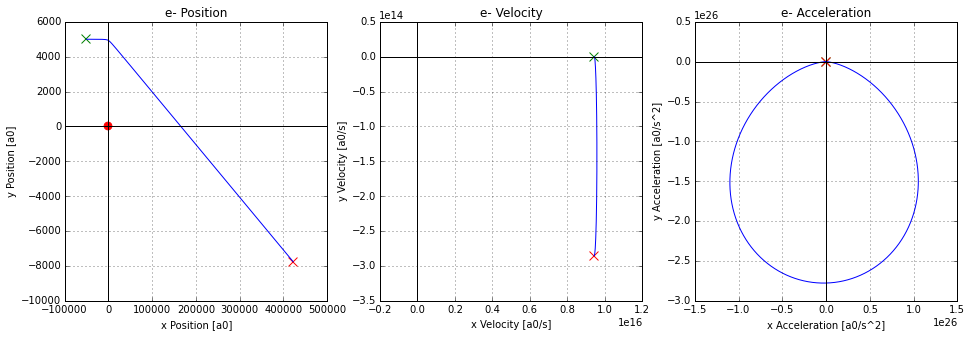

In [4]:
plt.figure(0, figsize = (16,5))
plt.subplot(131)
plt.plot(r[:, 0]/r_bohr, r[:, 1]/r_bohr)
plt.scatter(0, 0, marker ='o', s = 60, color = 'r')
plt.scatter(x0/r_bohr, y0/r_bohr, marker ='x', s = 80, color = 'g')
# put a circle at the origin for the ion
plt.scatter(r[-1, 0]/r_bohr, r[-1, 1]/r_bohr, marker ='x', s = 80, color = 'r')
plt.grid(True)
plt.axhline(y = 0, color = 'k')
plt.axvline(x = 0, color = 'k')
plt.xlabel('x Position [a0]')
plt.ylabel('y Position [a0]')
plt.title('e- Position')
plt.subplot(132)
plt.plot(v[:, 0]/r_bohr, v[:, 1]/r_bohr)
plt.scatter(v0_x/r_bohr, v0_y, marker ='x', s = 80, color = 'g')
plt.scatter(v[-1, 0]/r_bohr, v[-1, 1]/r_bohr, marker ='x', s = 80, color = 'r')
plt.grid(True)
plt.axhline(y = 0, color = 'k')
plt.axvline(x = 0, color = 'k')
plt.xlabel('x Velocity [a0/s]')
plt.ylabel('y Velocity [a0/s]')
plt.title('e- Velocity')
plt.subplot(133)
plt.plot(a[:, 0]/r_bohr, a[:, 1]/r_bohr)
plt.scatter(0, 0, marker ='x', s = 80, color = 'g')
plt.scatter(a[-1, 0]/r_bohr, a[-1, 1]/r_bohr, marker ='x', s = 80, color = 'r')
plt.grid(True)
plt.axhline(y = 0, color = 'k')
plt.axvline(x = 0, color = 'k')
plt.xlabel('x Acceleration [a0/s^2]')
plt.ylabel('y Acceleration [a0/s^2]')
plt.title('e- Acceleration')

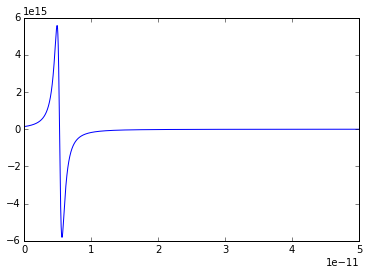

In [5]:
plt.figure(2)
plt.plot(np.linspace(0, N_t*dt, N_t - 1), a[:, 0])

For all this FT business we have to throw away the part of the spectrum that is above the Nyquist frequency (just the last half of the FT data).

In [6]:
a_avg = np.zeros(N_t)
ax_fft = scipy.fftpack.fft(a[:, 0])
ax_fft_abs = np.abs(ax_fft[0:N_t/2])
ay_fft = scipy.fftpack.fft(a[:, 1])
a_avg_fft = np.sqrt(np.absolute(ax_fft)**2 + np.absolute(ay_fft)**2)
P = 2./3*k*q**2*a_avg_fft**2/c**3
f = np.fft.fftfreq(N_t, dt)[:N_t/2]

(0, 5000000000000.0)

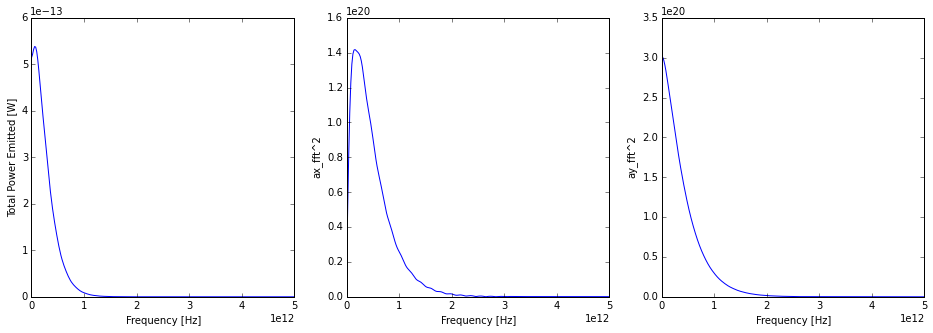

In [7]:
plt.figure(2, figsize = (16,5))
plt.subplot(131)
plt.plot(f, P[0:N_t/2])
#plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Total Power Emitted [W]')
plt.xlim((0,5e12))
plt.subplot(132)
plt.plot(f, np.abs(ax_fft_abs))
#plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ax_fft^2')
plt.xlim((0,5e12))
plt.subplot(133)
plt.plot(f, np.abs(ay_fft[0:N_t/2]))
#plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ay_fft^2')
plt.xlim((0,5e12))

So the power from the ay FT is higher than from the ax FT over most of the band. And there is no peak in ay_fft. Interesting...guess I'll just use the ax_fft data since combining swamps out the peak.

In [8]:
def sim(x0, y0, v0_x, v0_y, N_t, dt):
    # initialize arrays
    r = np.zeros((N_t - 1, 2))
    v = np.zeros((N_t - 1, 2))
    a = np.zeros((N_t - 1, 2))

    # calulate initial conidtions from definitions above
    theta = np.arctan2(y0, x0)
    a0 = Z*q*(-q)/m_e/(x0**2 + y0**2)
    a0_x = a0*np.cos(theta)
    a0_y = a0*np.sin(theta)

    for i in range(N_t - 1):
        if i == 0:
            # store initial conditions
            r[i, :] = (x0, y0)
            v[i, :] = (v0_x, v0_y)
            a[i, :] = (a0_x, a0_y)
        else:
            # caluclate change in e- position based on old v and a
            dr = (v[i - 1, 0]*dt + 1/2*a[i - 1, 0]*dt**2, v[i - 1, 1]*dt + 1/2*a[i - 1, 1]*dt**2)
            r[i, :] = r[i - 1, :] + dr

            # basically doing polar corrdinates and getting x and y components using abs(a) and theta
            theta = np.arctan2(r[i, 1], r[i, 0])
            a_new = k*Z*q*(-q)/m_e/(r[i, 0]**2 + r[i, 1]**2)
            ax = a_new*np.cos(theta)
            ay = a_new*np.sin(theta)
            # new a
            a[i, :] = (ax, ay)

            # change in v and new v
            dv = (a[i - 1, 0]*dt, a[i - 1, 1]*dt)
            v[i, :] = v[i - 1, :] + dv
    
    return r, v, a

In [9]:
v0_x_min = 1e5
v0_x_max = 5e6
v0_x_step = 2e5
f = np.fft.fftfreq(N_t, dt)[0:N_t/2]
for v0_x in np.arange(v0_x_min, v0_x_max, v0_x_step):
    print 'v0_x =', v0_x
    r, v, a = sim(-5e4*r_bohr, 5.0e3*r_bohr, v0_x, 0, N_t, dt)
    ax = a[:, 0]
    ax_fft = scipy.fftpack.fft(ax)[0:N_t/2]
    ax_fft_abs = np.abs(ax_fft)
    max_index = np.where(ax_fft_abs == np.max(ax_fft_abs))[0][0]
    
    if v0_x == v0_x_min:
        ax_f_max_v0 = f[max_index]
    else:
        ax_f_max_temp = f[max_index]
        ax_f_max_v0 = np.vstack((ax_f_max_v0, ax_f_max_temp))

v0_x = 100000.0
v0_x = 300000.0
v0_x = 500000.0
v0_x = 700000.0
v0_x = 900000.0
v0_x = 1100000.0
v0_x = 1300000.0
v0_x = 1500000.0
v0_x = 1700000.0
v0_x = 1900000.0
v0_x = 2100000.0
v0_x = 2300000.0
v0_x = 2500000.0
v0_x = 2700000.0
v0_x = 2900000.0
v0_x = 3100000.0
v0_x = 3300000.0
v0_x = 3500000.0
v0_x = 3700000.0
v0_x = 3900000.0
v0_x = 4100000.0
v0_x = 4300000.0
v0_x = 4500000.0
v0_x = 4700000.0
v0_x = 4900000.0


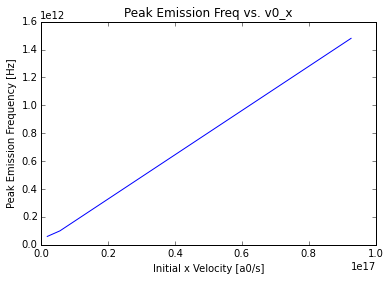

In [17]:
plt.figure(4)
plt.plot(np.arange(v0_x_min, v0_x_max, v0_x_step)/r_bohr, ax_f_max_v0)
plt.xlabel('Initial x Velocity [a0/s]')
plt.ylabel('Peak Emission Frequency [Hz]')
plt.title('Peak Emission Freq vs. v0_x')

In [11]:
y0_min = 1e3*r_bohr
y0_max = 5e4*r_bohr
y0_step = 2e3*r_bohr
f = np.fft.fftfreq(N_t, dt)[0:N_t/2]
ax_f_max_y0 = np.array([])
for y0 in np.arange(y0_min, y0_max, y0_step):
    print 'y0 =', y0
    r, v, a = sim(-5e4*r_bohr, y0, 5e5, 0, N_t, dt)
    ax = a[:, 0]
    ax_fft = scipy.fftpack.fft(ax)[0:N_t/2]
    ax_fft_abs = np.abs(ax_fft)    
    max_index = np.where(ax_fft_abs == np.max(ax_fft_abs))[0][0]
    
    if y0 == y0_min:
        ax_f_max_y0 = f[max_index]
    else:
        ax_f_max_temp = f[max_index]
        ax_f_max_y0 = np.vstack((ax_f_max_y0, ax_f_max_temp))

y0 = 5.29e-08
y0 = 1.587e-07
y0 = 2.645e-07
y0 = 3.703e-07
y0 = 4.761e-07
y0 = 5.819e-07
y0 = 6.877e-07
y0 = 7.935e-07
y0 = 8.993e-07
y0 = 1.0051e-06
y0 = 1.1109e-06
y0 = 1.2167e-06
y0 = 1.3225e-06
y0 = 1.4283e-06
y0 = 1.5341e-06
y0 = 1.6399e-06
y0 = 1.7457e-06
y0 = 1.8515e-06
y0 = 1.9573e-06
y0 = 2.0631e-06
y0 = 2.1689e-06
y0 = 2.2747e-06
y0 = 2.3805e-06
y0 = 2.4863e-06
y0 = 2.5921e-06


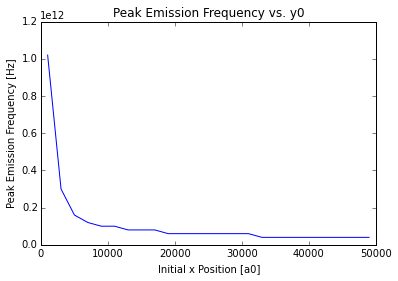

In [16]:
plt.figure(5)
plt.plot(np.arange(y0_min, y0_max, y0_step)/r_bohr, ax_f_max_y0)
plt.xlabel('Initial x Position [a0]')
plt.ylabel('Peak Emission Frequency [Hz]')
plt.title('Peak Emission Frequency vs. y0')